In [2]:
from datasets import load_dataset

dataset = load_dataset("sms_spam")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})


In [6]:
print(dataset['train'][8])

{'sms': 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.\n', 'label': 1}


In [8]:
print(dataset['train'].features['label'])

ClassLabel(names=['ham', 'spam'])


#investigating TfidfVectorizer


In [12]:
text = [
    "I won the lottery",
    "you won a lottery",
    "Congratulations! we are happy to offer you SDE-1 role at Amazon"
]
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 500)
X = vectorizer.fit_transform(text)

print("shappe of TF-IDF matrix:", X.shape)
print("Example of feature names:", vectorizer.get_feature_names_out()[:20])


shappe of TF-IDF matrix: (3, 8)
Example of feature names: ['amazon' 'congratulations' 'happy' 'lottery' 'offer' 'role' 'sde' 'won']


Vectorizing the dataset! getting ready for that prediction

In [15]:
# doing the split with Hugging Face to avoid weird indexing issues
splits = dataset['train'].train_test_split(test_size=0.2, seed=42, stratify_by_column='label')

# pulling out the text and labels as plain lists (keeping it simple)
train_texts = list(splits['train']['sms'])
train_labels = list(map(int, splits['train']['label']))
test_texts  = list(splits['test']['sms'])
test_labels = list(map(int, splits['test']['label']))

# vectorizing with tf-idf — small cap on features to stay fast
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# fitting on train only, then applying to test
X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)

# sanity check — rows = docs, cols = vocab size
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

# quick peek at what words made it in
print("Example features:", vectorizer.get_feature_names_out()[:20])


X_train shape: (4459, 5000)
X_test  shape: (1115, 5000)
Example features: ['00' '000' '008704050406' '01223585334' '02' '0207' '02073162414'
 '02085076972' '021' '03' '04' '0430' '05' '050703' '0578' '06' '07'
 '07008009200' '07046744435' '07123456789']


In [17]:
# training a simple baseline so I have a reference point
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

# fitting the model on the tf-idf features
clf = LogisticRegression(max_iter=2000, n_jobs=-1)  # cranking up max_iter just in case
clf.fit(X_train, train_labels)

# getting predictions on the test set to see how well it generalizes
test_pred = clf.predict(X_test)

# quick metrics to get the vibe (accuracy + macro-F1 for imbalance)
acc = accuracy_score(test_labels, test_pred)
f1  = f1_score(test_labels, test_pred, average='macro')
print("test accuracy:", acc)
print("macro-F1:", f1)
print("\nclassification report:\n", classification_report(test_labels, test_pred, digits=3, target_names=["ham","spam"]))

test accuracy: 0.9659192825112107
macro-F1: 0.9183660100496316

classification report:
               precision    recall  f1-score   support

         ham      0.964     0.998     0.981       966
        spam      0.983     0.758     0.856       149

    accuracy                          0.966      1115
   macro avg      0.973     0.878     0.918      1115
weighted avg      0.966     0.966     0.964      1115



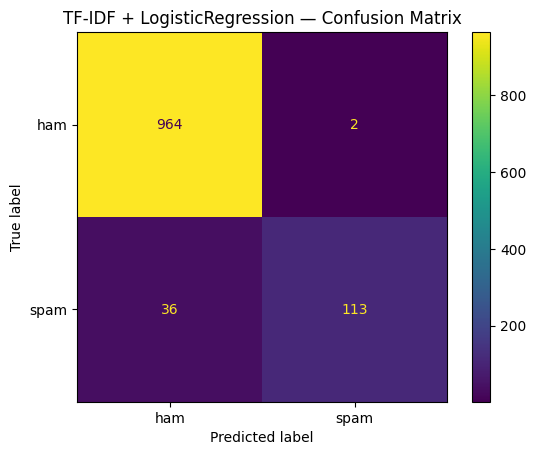

In [18]:
# drawing the confusion matrix to see *how* it’s making mistakes
cm = confusion_matrix(test_labels, test_pred, labels=[0,1])  # 0=ham, 1=spam
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham","spam"])
disp.plot(values_format="d")
plt.title("TF-IDF + LogisticRegression — Confusion Matrix")
plt.show()